<span style="font-size:xx-large;">**Refining European Crop Mapping Classification through the Integration of Permanent Crops: A Case Study in Rapidly Transitioning Irrigated Landscapes Induced by Dam Construction**</span>

<span style="font-size:x-large;">**1 - Import Libraries**</span>

In [1]:
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import glob

from collections import defaultdict
from rasterio.mask import mask
from scipy.stats import entropy
from shapely.geometry import shape
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
%matplotlib inline
labels = []

<span style="font-size:x-large;">**2 - Name output files**</span>

In [2]:
'''
NAME THE VARIOUS OUTPUT FILES.

'''

NAME = 'PC_Alentejo'

'''
Others
'''

CPUsselected = 7

<span style="font-size:x-large;">**3 - Build model**</span>

In [3]:
# Read Data Set
sample_data = pd.read_csv("DataSet/DataSet.csv")
sample_data

,0_VV,0_VH,1_VHVV,2_VV,2_VH,3_VHVV,4_VV,4_VH,5_VHVV,6_VV,...,12_NDMIR,NDVI_stdDev,NDWI_stdDev,NBR_stdDev,NDBI_stdDev,NDMIR_stdDev,VV_stdDev,VH_stdDev,VHVV_stdDev,class
0,-7.876853,-16.261530,0.156865,-11.113940,-16.392437,0.267877,-9.005363,-14.826082,0.242085,-8.645480,...,0.263863,0.022975,0.018306,0.005751,0.004120,0.002299,0.196322,0.191167,0.011936,1
1,-7.589051,-15.840921,0.126286,-10.703953,-16.088713,0.294299,-6.747023,-13.796914,0.154396,-7.922736,...,0.268022,0.004307,0.007211,0.005417,0.003991,0.002994,0.127695,0.071970,0.007058,1
2,-9.484901,-18.068977,0.153161,-11.163893,-19.442368,0.185143,-11.167763,-16.437160,0.227979,-10.364755,...,0.272652,0.019451,0.016257,0.015325,0.010738,0.005826,0.199045,0.111943,0.011951,3
3,-10.785257,-17.287561,0.217466,-13.081150,-17.967772,0.341907,-10.777059,-16.254379,0.283807,-10.754288,...,0.288152,0.029671,0.024546,0.017448,0.013350,0.005110,0.163741,0.097982,0.009339,3
4,-11.657923,-17.676895,0.279875,-12.642226,-18.065292,0.272394,-8.983940,-15.632057,0.250515,-9.508293,...,0.313660,0.026904,0.019853,0.018107,0.012160,0.007836,0.195973,0.277762,0.007620,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25393,-6.082663,-22.506599,0.021608,-8.284382,-23.436457,0.027129,-4.756191,-18.874561,0.028265,-5.699284,...,0.161203,0.003137,0.001001,0.000705,0.001140,0.000517,0.241069,0.301525,0.007096,6
25394,-8.710595,-19.665478,0.085167,-10.766340,-21.110659,0.076511,-7.025453,-19.888796,0.085080,-10.394036,...,0.185812,0.015997,0.012863,0.000802,0.001475,0.001977,0.106627,0.167349,0.003052,6
25395,-7.349567,-19.976271,0.067020,-10.044423,-21.073727,0.089456,-7.412088,-17.247206,0.077520,-6.451970,...,0.240810,0.007747,0.007915,0.001614,0.002693,0.001382,0.354585,0.191783,0.014926,6
25396,-7.599626,-19.952223,0.058645,-12.131800,-20.626373,0.102510,-8.622043,-18.057339,0.103073,-8.527523,...,0.272018,0.006602,0.004421,0.002133,0.002383,0.001274,0.388734,0.181561,0.010779,6


In [4]:
# Count the number of records in each class
class_counts = sample_data['class'].value_counts()

# Print the result
print(class_counts)

class
7    14826
4     5018
5     2526
2      782
3      706
1      668
8      626
6      246
Name: count, dtype: int64


In [5]:
# define the predictor features of the model
X = sample_data.drop(['class'],axis=1)

In [6]:
# define the label feature of the model
y = sample_data['class']

In [7]:
# create the train and test subsets
X_train, X_test, y_train, y_test = train_test_split( 
    X, 
    y, 
    train_size=0.8, 
    random_state=42,
    #stratify=y
    )

print ('Train set:', X_train.shape,  y_train.shape,)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (20318, 104) (20318,)
Test set: (5080, 104) (5080,)


In [8]:
#See division
y_train.value_counts(), y_test.value_counts()

(class
 7    11789
 4     4036
 5     2054
 2      637
 1      549
 3      546
 8      501
 6      206
 Name: count, dtype: int64,
 class
 7    3037
 4     982
 5     472
 3     160
 2     145
 8     125
 1     119
 6      40
 Name: count, dtype: int64)

In [9]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0_VV,20318.0,-11.040218,1.399005,-17.198196,-11.948798,-11.089116,-10.201378,-3.205022
0_VH,20318.0,-17.656722,1.439454,-24.372152,-18.564419,-17.594268,-16.693304,-11.570633
1_VHVV,20318.0,0.231470,0.076708,0.021608,0.177217,0.223019,0.275553,0.750451
2_VV,20318.0,-11.784499,1.409647,-16.974836,-12.693829,-11.802557,-10.903172,-3.255687
2_VH,20318.0,-18.097318,1.511584,-26.245104,-19.062980,-18.049090,-17.074696,-12.218232
...,...,...,...,...,...,...,...,...
NDBI_stdDev,20318.0,0.010868,0.009629,0.000000,0.004254,0.008120,0.014476,0.118495
NDMIR_stdDev,20318.0,0.004981,0.004282,0.000000,0.002022,0.003795,0.006674,0.042037
VV_stdDev,20318.0,0.234963,0.141418,0.005211,0.137905,0.201167,0.295731,1.920560
VH_stdDev,20318.0,0.242330,0.151279,0.013229,0.141360,0.204248,0.301256,1.597591


<span style="font-size:small;">**Cross validation for better parameters**</span>

In [10]:
'''
classifier = RandomForestClassifier(random_state=42)
'''

'\nclassifier = RandomForestClassifier(random_state=42)\n'

In [11]:
'''
# to find best hyperparameters for the model, we will test several
param_grCV = {
    'n_estimators': [900, 800, 700, 600, 500, 400, 300, 200],
    'max_features': ['sqrt','log2'],
    'criterion' :['gini','entropy'],
}
'''

"\n# to find best hyperparameters for the model, we will test several\nparam_grCV = {\n    'n_estimators': [900, 800, 700, 600, 500, 400, 300, 200],\n    'max_features': ['sqrt','log2'],\n    'criterion' :['gini','entropy'],\n}\n"

In [12]:
'''
CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc.fit(X_train, y_train)
'''

'\nCV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc.fit(X_train, y_train)\n'

In [13]:
'''
CV_rfc.best_params_
'''

'\nCV_rfc.best_params_\n'

In [14]:
'''
classifier = CV_rfc.best_estimator_
'''

'\nclassifier = CV_rfc.best_estimator_\n'

<span style="font-size:small;">**End of cross validation for better parameters**</span>

In [15]:
# to find best hyperparameters for the model, we will test several

param_gr = {
    'n_estimators': 600,
    'max_features': 'sqrt',
    'max_depth' : None,
    'criterion' :'entropy',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
    
}

In [16]:

classifier = RandomForestClassifier(**param_gr)


In [17]:
%%time
classifier.fit(X_train, y_train)

CPU times: total: 4min 55s
Wall time: 44.4 s


RandomForestClassifier(criterion='entropy', n_estimators=600, n_jobs=7,
                       random_state=42, warm_start=True)

<span style="font-size:x-large;">**4 - Model Validation**</span>

In [18]:
score = classifier.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.90748031496063


In [19]:
# Calculate the model save results
y_pred = classifier.predict(X_test)

In [20]:
#F1 report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

with open(f'Model/ClassificationReport_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report)

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.57      0.71       119
           2       0.90      0.89      0.90       145
           3       0.96      0.66      0.78       160
           4       0.86      0.93      0.89       982
           5       0.91      0.72      0.80       472
           6       0.93      0.33      0.48        40
           7       0.92      0.99      0.96      3037
           8       0.82      0.26      0.40       125

    accuracy                           0.91      5080
   macro avg       0.91      0.67      0.74      5080
weighted avg       0.91      0.91      0.90      5080



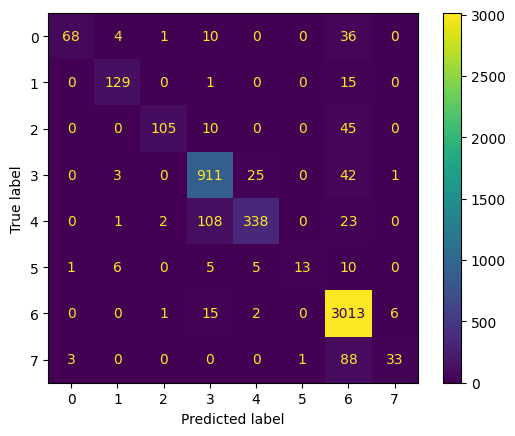

In [21]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

cm_display.figure_.savefig(f'Model/confusionMatrix_{NAME}.png')

<span style="font-size:x-large;">**5 - Feature Evaluation**</span>

<span style="font-size:normal;">**5.1 - MDA - Mean Decrease Accuracy**</span>

In [22]:

%%time
permutation_importance_results = permutation_importance(
    estimator = classifier,
    X = X_test,
    y = y_test,
    scoring = 'accuracy',
    n_repeats = 50)
sorted_idx = permutation_importance_results.importances_mean.argsort()
ImportanciaFeaturesPBI = pd.DataFrame({'Feature':X_test.columns[sorted_idx], 'Importância':permutation_importance_results.importances_mean[sorted_idx]})


CPU times: total: 57min 47s
Wall time: 15min 36s


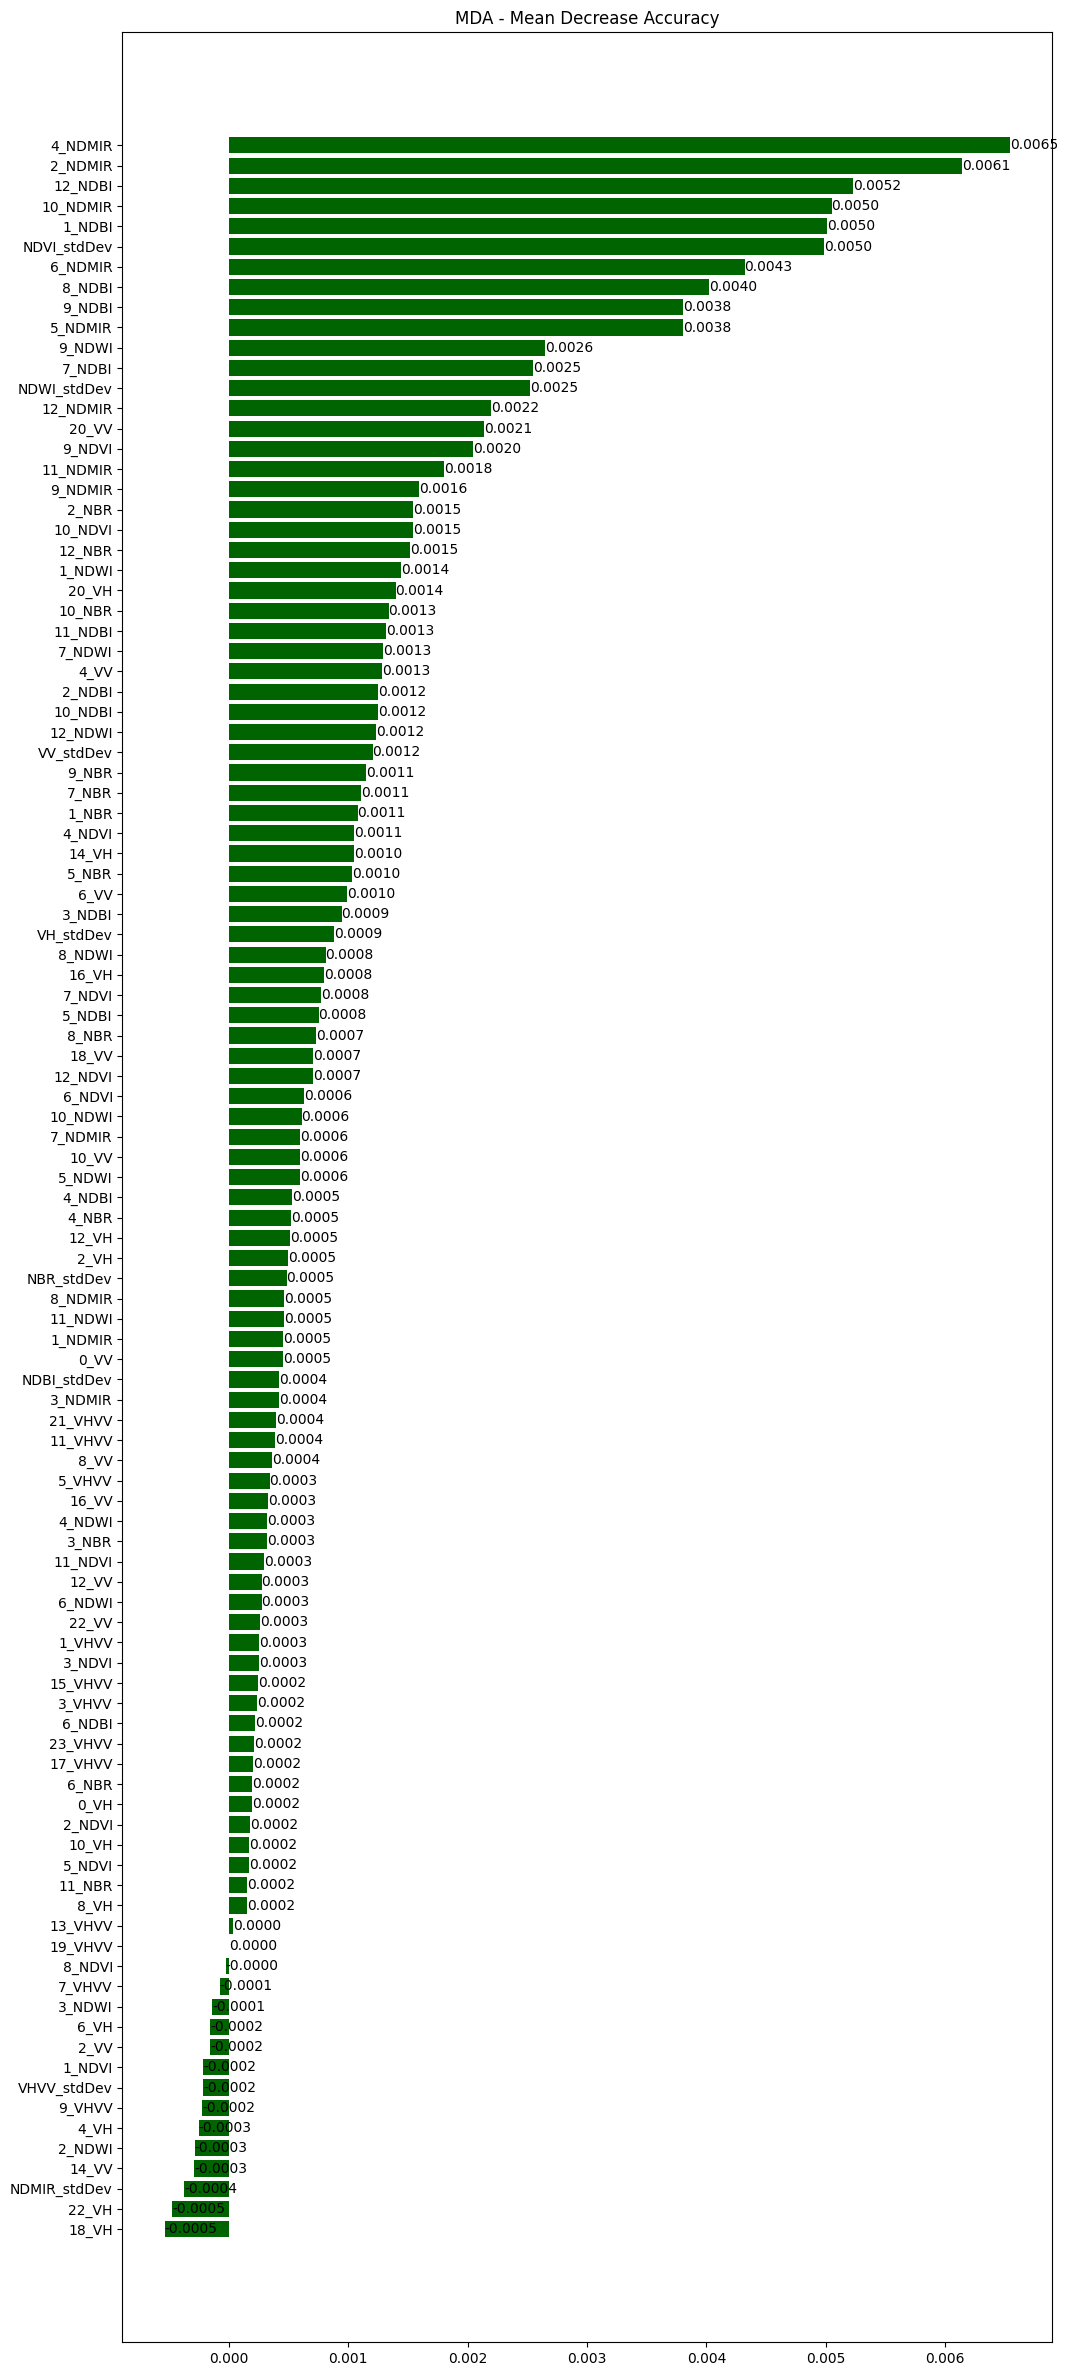

In [23]:
#Plot

plt.figure(figsize=(12,30))
bars1 = plt.barh(ImportanciaFeaturesPBI['Feature'],ImportanciaFeaturesPBI['Importância'], color='darkgreen')
plt.title("MDA - Mean Decrease Accuracy")
for bar in bars1:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}', 
        va='center', ha='left'
    )
plt.show()

In [24]:
#Export

ImportanciaFeaturesPBI.to_csv(f'Model/MDA_{NAME}.csv', index=False)


<span style="font-size:normal;">**5.2 - MDI - Mean Decrease Impurity**</span>

In [25]:

%%time
permutation_importance_results_MDI = classifier.feature_importances_
ImportanciaFeaturesMDI = pd.DataFrame({'Feature':X_train.columns, 'Importância':permutation_importance_results_MDI})
ImportanciaFeaturesMDI = ImportanciaFeaturesMDI.sort_values(by='Importância', ascending=True)


CPU times: total: 93.8 ms
Wall time: 78.8 ms


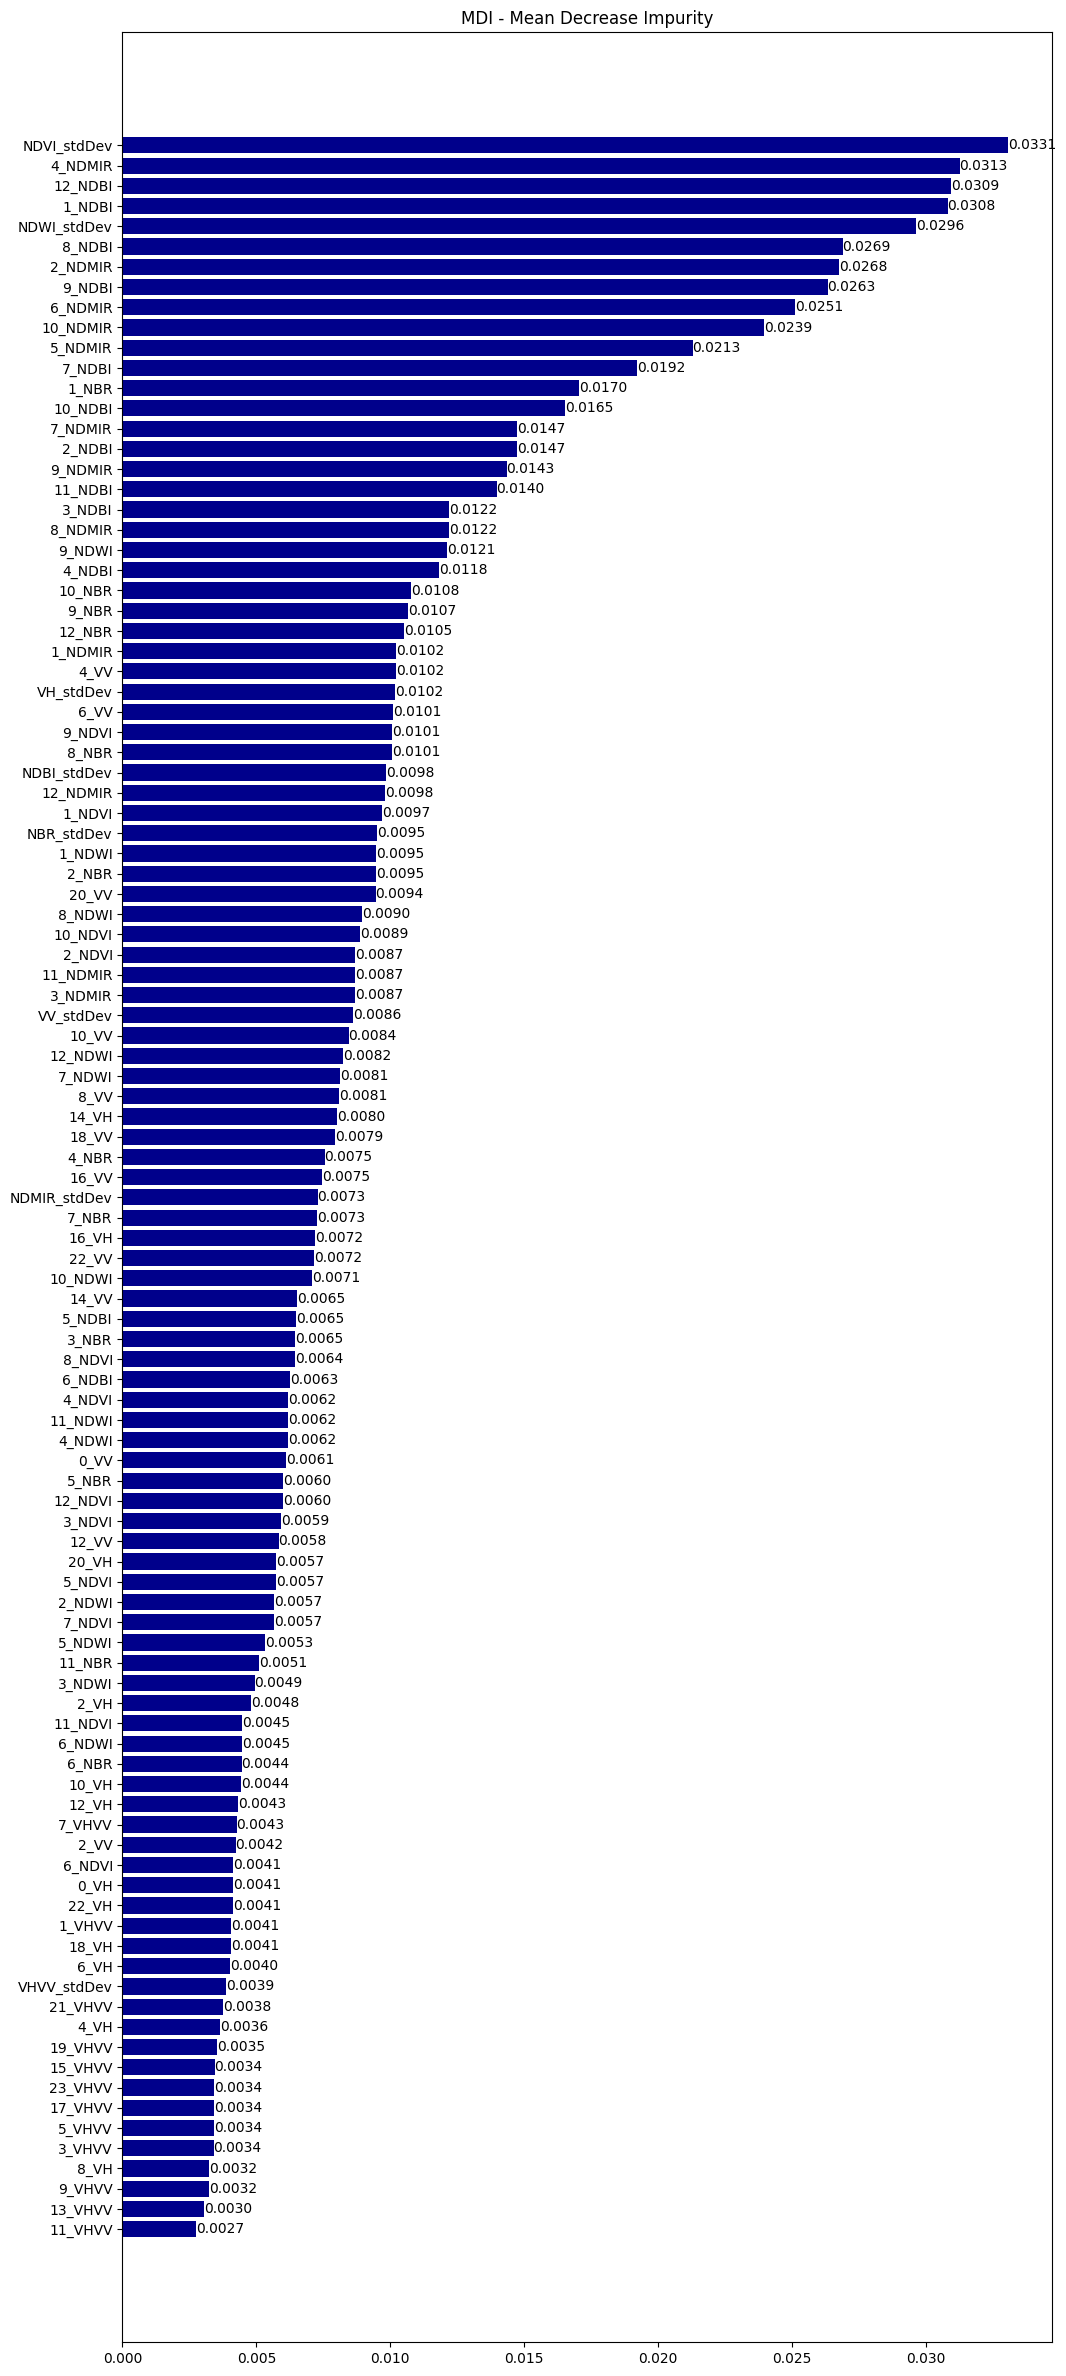

In [26]:
#Plot

plt.figure(figsize=(12,30))
bars2 = plt.barh(ImportanciaFeaturesMDI['Feature'], ImportanciaFeaturesMDI['Importância'], color='darkblue')
plt.title("MDI - Mean Decrease Impurity")
for bar in bars2:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}', 
        va='center', ha='left'
    )
plt.show()


In [27]:
#Export

ImportanciaFeaturesMDI.to_csv(f'Model/MDI_{NAME}.csv', index=False)


<span style="font-size:x-large;">**6 - Create Map**</span>

<span style="font-size:large;">**6.1 - Create Maps all at once**</span>

In [28]:
'''
# Folder containing the stacks
stack_dir = 'Stack/'
output_dir = 'Maps/'

#Initiate stack classification and map generation
column_names_pandas = sample_data.columns.tolist()

for stack_path in glob.glob(os.path.join(stack_dir, "*.tif")):
    nome_stack = os.path.splitext(os.path.basename(stack_path))[0]
    rst = rasterio.open(stack_path)
    bandas_stack = rst.descriptions  # Nomes das bandas no stack

    print(f"Processando stack: {nome_stack}")
    print("Bandas no stack:", bandas_stack)
    print("Colunas da amostra:", column_names_pandas)

    stack_data = rst.read()
    indices_selecionados = [bandas_stack.index(banda) for banda in column_names_pandas if banda in bandas_stack]

    print("Índices selecionados:", indices_selecionados)
    print("Número total de bandas no stack:", len(indices_selecionados))

    stack_data_selecionado = stack_data[indices_selecionados]
    mask_nan = np.any(np.isnan(stack_data_selecionado), axis=0)
    stack_data_selecionado[np.isnan(stack_data_selecionado)] = 0
    n_bands, n_rows, n_cols = stack_data_selecionado.shape
    reshaped_data = stack_data_selecionado.reshape((n_bands, n_rows * n_cols)).T

    predicted_labels = classifier.predict(reshaped_data)
    predicted_labels = predicted_labels.reshape((n_rows, n_cols))
    predicted_labels = np.array(predicted_labels, dtype=np.float32)
    predicted_labels[mask_nan] = np.nan

    transform = rst.transform

    output_map_path = os.path.join(output_dir, f'Mapa_{nome_stack}.tif')
    
    with rasterio.open(output_map_path, 'w', driver='GTiff', height=n_rows, width=n_cols, count=1, dtype=np.float32, crs=rst.crs) as dst:
        dst.write(predicted_labels, 1)  
        dst.transform = transform 
        dst.crs = rst.crs
    
    print(f"Mapa gerado: {output_map_path}")

print("Classificação de todos os stacks concluída.")
'''

'\n# Folder containing the stacks\nstack_dir = \'Stack/\'\noutput_dir = \'Maps/\'\n\n#Initiate stack classification and map generation\ncolumn_names_pandas = sample_data.columns.tolist()\n\nfor stack_path in glob.glob(os.path.join(stack_dir, "*.tif")):\n    nome_stack = os.path.splitext(os.path.basename(stack_path))[0]\n    rst = rasterio.open(stack_path)\n    bandas_stack = rst.descriptions  # Nomes das bandas no stack\n\n    print(f"Processando stack: {nome_stack}")\n    print("Bandas no stack:", bandas_stack)\n    print("Colunas da amostra:", column_names_pandas)\n\n    stack_data = rst.read()\n    indices_selecionados = [bandas_stack.index(banda) for banda in column_names_pandas if banda in bandas_stack]\n\n    print("Índices selecionados:", indices_selecionados)\n    print("Número total de bandas no stack:", len(indices_selecionados))\n\n    stack_data_selecionado = stack_data[indices_selecionados]\n    mask_nan = np.any(np.isnan(stack_data_selecionado), axis=0)\n    stack_data_se

<span style="font-size:large;">**6.2 - Create Map One by One**</span>

In [29]:
'''
#Select stack and name map

Cluster = 1

#Initiate stack classification and map generation
rst = rasterio.open(f'Stack/Stack_{Cluster}.tif')
bandas_stack  = rst.descriptions
column_names_pandas = sample_data.columns.tolist()
print(bandas_stack )
print(column_names_pandas)
stack_data = rst.read()
indices_selecionados = [bandas_stack.index(banda) for banda in column_names_pandas if banda in bandas_stack]

print("Índices selecionados:", indices_selecionados)
print("Número total de bandas no stack:", len(indices_selecionados))

stack_data_selecionado = stack_data[indices_selecionados]
mask_nan = np.any(np.isnan(stack_data_selecionado), axis=0)
stack_data_selecionado[np.isnan(stack_data_selecionado)] = 0
n_bands, n_rows, n_cols = stack_data_selecionado.shape
reshaped_data = stack_data_selecionado.reshape((n_bands, n_rows * n_cols)).T

predicted_labels = classifier.predict(reshaped_data)
predicted_labels = predicted_labels.reshape((n_rows, n_cols))
predicted_labels = np.array(predicted_labels, dtype=np.float32)
predicted_labels[mask_nan] = np.nan
#predicted_labels = np.array(predicted_labels, dtype=np.uint8)

transform = rst.transform

with rasterio.open(f'Maps/Map_{Cluster}.tif', 'w', driver='GTiff', height=n_rows, width=n_cols, count=1, dtype=np.float32, crs=rst.crs) as dst:
    dst.write(predicted_labels, 1)  # Escreva a imagem classificada
    dst.transform = transform  # Defina a transformação
    dst.crs = rst.crs  # Defina o sistema de coordenadas
'''

'\n#Select stack and name map\n\nCluster = 1\n\n#Initiate stack classification and map generation\nrst = rasterio.open(f\'Stack/Stack_{Cluster}.tif\')\nbandas_stack  = rst.descriptions\ncolumn_names_pandas = sample_data.columns.tolist()\nprint(bandas_stack )\nprint(column_names_pandas)\nstack_data = rst.read()\nindices_selecionados = [bandas_stack.index(banda) for banda in column_names_pandas if banda in bandas_stack]\n\nprint("Índices selecionados:", indices_selecionados)\nprint("Número total de bandas no stack:", len(indices_selecionados))\n\nstack_data_selecionado = stack_data[indices_selecionados]\nmask_nan = np.any(np.isnan(stack_data_selecionado), axis=0)\nstack_data_selecionado[np.isnan(stack_data_selecionado)] = 0\nn_bands, n_rows, n_cols = stack_data_selecionado.shape\nreshaped_data = stack_data_selecionado.reshape((n_bands, n_rows * n_cols)).T\n\npredicted_labels = classifier.predict(reshaped_data)\npredicted_labels = predicted_labels.reshape((n_rows, n_cols))\npredicted_labe

<span style="font-size:xx-large;">**Gradual Reduction of the Training Set**</span>

<span style="font-size:xx-large;">**75% of the Train Set**</span>

In [30]:
#Create the train and test subsets to 75%
X_train75, X_test75, y_train75, y_test75 = train_test_split( 
    X_train, 
    y_train, 
    train_size=0.75, 
    random_state=42,
    stratify=y_train
    )

print ('Train set:', X_train75.shape,  y_train75.shape)

Train set: (15238, 104) (15238,)


In [31]:
#Count division
y_train75.value_counts()

class
7    8841
4    3027
5    1540
2     478
1     412
3     409
8     376
6     155
Name: count, dtype: int64

<span>**Cross validation for better parameters**</span>

In [32]:
'''
classifier75 = RandomForestClassifier(random_state=42)
'''

'\nclassifier75 = RandomForestClassifier(random_state=42)\n'

In [33]:
'''
CV_rfc75 = GridSearchCV(estimator=classifier75, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc75.fit(X_train75, y_train75)
'''

'\nCV_rfc75 = GridSearchCV(estimator=classifier75, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc75.fit(X_train75, y_train75)\n'

In [34]:
'''
CV_rfc75.best_params_
'''

'\nCV_rfc75.best_params_\n'

In [35]:
'''
classifier75 = CV_rfc75.best_estimator_
'''

'\nclassifier75 = CV_rfc75.best_estimator_\n'

------------------------------------------------------------------------------------

<span>**End of cross validation for better parameters**</span>

In [36]:

param_gr75 = {
    'n_estimators': 600,
    'max_features': 'sqrt',
    'max_depth' : None,
    'criterion' :'entropy',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
}


In [37]:

#Create the RF object. Hyperparameters obtained from Data transformation
classifier75 = RandomForestClassifier(**param_gr75)


<span>**Model 75 construction**</span>

In [38]:
%%time
classifier75.fit(X_train75, y_train75)

CPU times: total: 3min 37s
Wall time: 32.8 s


RandomForestClassifier(criterion='entropy', n_estimators=600, n_jobs=7,
                       random_state=42, warm_start=True)

<span style="font-size:large;">**Validation for 75%**</span>

In [39]:
score75 = classifier75.score(X_test, y_test)
print('Average accuracy score: {}'.format(score75))

Average accuracy score: 0.9003937007874016


In [40]:
#Calculate the model save results
y_pred75 = classifier75.predict(X_test)

In [41]:
#F1 report
report75 = classification_report(y_test, y_pred75)
print("Classification Report:\n", report75)

with open(f'Model/ClassificationReport75_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report75)

Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.51      0.65       119
           2       0.86      0.88      0.87       145
           3       0.97      0.58      0.73       160
           4       0.85      0.93      0.89       982
           5       0.91      0.69      0.79       472
           6       0.91      0.25      0.39        40
           7       0.91      0.99      0.95      3037
           8       0.86      0.25      0.39       125

    accuracy                           0.90      5080
   macro avg       0.90      0.64      0.71      5080
weighted avg       0.90      0.90      0.89      5080



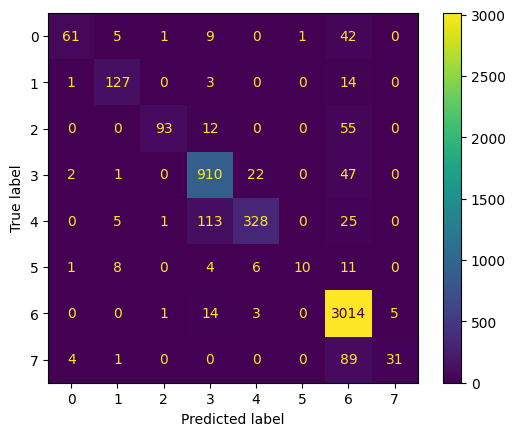

In [42]:
#Confusion matrix
cm75 = confusion_matrix(y_test, y_pred75)
cm_display75 = ConfusionMatrixDisplay(cm75).plot()

cm_display75.figure_.savefig(f'Model/confusionMatrix75_{NAME}.png')

<span style="font-size:xx-large;">**50% of the Train Set**</span>

In [43]:
#Create the train and test subsets to 50%
X_train50, X_test50, y_train50, y_test50 = train_test_split( 
    X_train, 
    y_train, 
    train_size=0.50, 
    random_state=42,
    stratify=y_train
    )

print ('Train set:', X_train50.shape,  y_train50.shape)

Train set: (10159, 104) (10159,)


In [44]:
#Count division
y_train50.value_counts()

class
7    5895
4    2018
5    1027
2     318
1     275
3     273
8     250
6     103
Name: count, dtype: int64

<span>**Cross validation for better parameters**</span>

In [45]:
'''
classifier50 = RandomForestClassifier(random_state=42)
'''

'\nclassifier50 = RandomForestClassifier(random_state=42)\n'

In [46]:
'''
CV_rfc50 = GridSearchCV(estimator=classifier50, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc50.fit(X_train50, y_train50)
'''

'\nCV_rfc50 = GridSearchCV(estimator=classifier50, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc50.fit(X_train50, y_train50)\n'

In [47]:
'''
CV_rfc50.best_params_
'''

'\nCV_rfc50.best_params_\n'

In [48]:
'''
classifier50 = CV_rfc50.best_estimator_
'''

'\nclassifier50 = CV_rfc50.best_estimator_\n'

<span>**End of cross validation for better parameters**</span>

In [49]:

param_gr50 = {
    'n_estimators': 700,
    'max_features': 'sqrt',
    'max_depth' : None,
    'criterion' :'entropy',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
}


In [50]:

# Create the RF object. Hyperparameters obtained from Data transformation
classifier50 = RandomForestClassifier(**param_gr50)


<span>**Model 50 construction**</span>

In [51]:
%%time
classifier50.fit(X_train50, y_train50)

CPU times: total: 2min 39s
Wall time: 23.5 s


RandomForestClassifier(criterion='entropy', n_estimators=700, n_jobs=7,
                       random_state=42, warm_start=True)

<span style="font-size:large;">**Validation for 50%**</span>

In [52]:
score50 = classifier50.score(X_test, y_test)
print('Average accuracy score: {}'.format(score50))

Average accuracy score: 0.8917322834645669


In [53]:
#Calculate the model save results
y_pred50 = classifier50.predict(X_test)

In [54]:
#F1 report
report50 = classification_report(y_test, y_pred50)
print("Classification Report:\n", report50)

with open(f'Model/ClassificationReport50_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report50)

Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.48      0.62       119
           2       0.87      0.86      0.87       145
           3       0.97      0.53      0.69       160
           4       0.84      0.92      0.88       982
           5       0.90      0.67      0.77       472
           6       0.88      0.17      0.29        40
           7       0.91      0.99      0.95      3037
           8       0.86      0.20      0.32       125

    accuracy                           0.89      5080
   macro avg       0.89      0.60      0.67      5080
weighted avg       0.89      0.89      0.88      5080



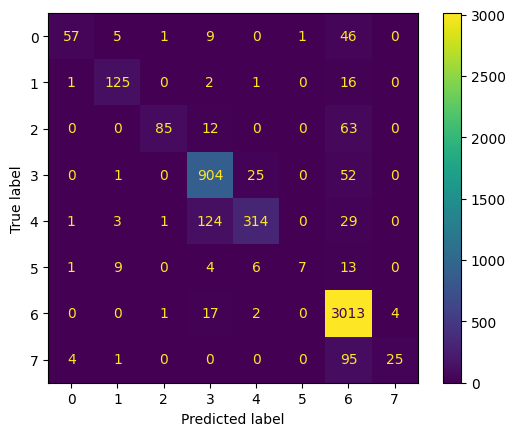

In [55]:
#Confusion matrix
cm50 = confusion_matrix(y_test, y_pred50)
cm_display50 = ConfusionMatrixDisplay(cm50).plot()

cm_display50.figure_.savefig(f'Model/confusionMatrix50_{NAME}.png')

<span style="font-size:xx-large;">**40% of the Train Set**</span>

In [56]:
#Create the train and test subsets to 50%
X_train40, X_test40, y_train40, y_test40 = train_test_split( 
    X_train, 
    y_train, 
    train_size=0.40, 
    random_state=42,
    stratify=y_train
    )

print ('Train set:', X_train40.shape,  y_train40.shape)

Train set: (8127, 104) (8127,)


In [57]:
#Count division
y_train40.value_counts()

class
7    4716
4    1614
5     822
2     255
1     220
3     218
8     200
6      82
Name: count, dtype: int64

<span>**Cross validation for better parameters**</span>

In [58]:
'''
classifier40 = RandomForestClassifier(random_state=42)
'''

'\nclassifier40 = RandomForestClassifier(random_state=42)\n'

In [59]:
'''
CV_rfc40 = GridSearchCV(estimator=classifier40, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc40.fit(X_train40, y_train40)
'''

'\nCV_rfc40 = GridSearchCV(estimator=classifier40, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc40.fit(X_train40, y_train40)\n'

In [60]:
'''
CV_rfc40.best_params_
'''

'\nCV_rfc40.best_params_\n'

In [61]:
'''
classifier40 = CV_rfc40.best_estimator_
'''

'\nclassifier40 = CV_rfc40.best_estimator_\n'

<span>**End of cross validation for better parameters**</span>

In [62]:

param_gr40 = {
    'n_estimators': 500,
    'max_features': 'sqrt',
    'max_depth' : None,
    'criterion' :'gini',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
}


In [63]:

#Create the RF object. Hyperparameters obtained from Data transformation
classifier40 = RandomForestClassifier(**param_gr40)


<span>**Model 40 construction**</span>

In [64]:
%%time
classifier40.fit(X_train40, y_train40)

CPU times: total: 55.2 s
Wall time: 8.24 s


RandomForestClassifier(n_estimators=500, n_jobs=7, random_state=42,
                       warm_start=True)

<span style="font-size:large;">**Validation for 40%**</span>

In [65]:
score40 = classifier40.score(X_test, y_test)
print('Average accuracy score: {}'.format(score40))

Average accuracy score: 0.8850393700787401


In [66]:
#Calculate the model save results
y_pred40 = classifier40.predict(X_test)

In [67]:
#F1 report
report40 = classification_report(y_test, y_pred40)
print("Classification Report:\n", report40)

with open(f'Model/ClassificationReport40_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report40)

Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.46      0.60       119
           2       0.85      0.85      0.85       145
           3       0.93      0.49      0.64       160
           4       0.83      0.91      0.87       982
           5       0.88      0.64      0.75       472
           6       1.00      0.20      0.33        40
           7       0.90      0.99      0.95      3037
           8       0.82      0.18      0.30       125

    accuracy                           0.89      5080
   macro avg       0.88      0.59      0.66      5080
weighted avg       0.88      0.89      0.87      5080



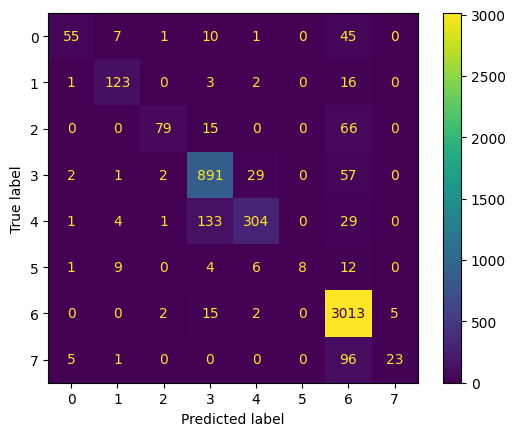

In [68]:
#Confusion matrix
cm40 = confusion_matrix(y_test, y_pred40)
cm_display40 = ConfusionMatrixDisplay(cm40).plot()

cm_display40.figure_.savefig(f'Model/confusionMatrix40_{NAME}.png')

<span style="font-size:xx-large;">**30% of the Train Set**</span>

In [69]:
#Create the train and test subsets to 50%
X_train30, X_test30, y_train30, y_test30 = train_test_split( 
    X_train, 
    y_train, 
    train_size=0.30, 
    random_state=42,
    stratify=y_train
    )

print ('Train set:', X_train30.shape,  y_train30.shape)

Train set: (6095, 104) (6095,)


In [70]:
#Count division
y_train30.value_counts()

class
7    3536
4    1211
5     616
2     191
1     165
3     164
8     150
6      62
Name: count, dtype: int64

<span>**Cross validation for better parameters**</span>

In [71]:
'''
classifier30 = RandomForestClassifier(random_state=42)
'''

'\nclassifier30 = RandomForestClassifier(random_state=42)\n'

In [72]:
'''
CV_rfc30 = GridSearchCV(estimator=classifier30, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc30.fit(X_train30, y_train30)
'''

'\nCV_rfc30 = GridSearchCV(estimator=classifier30, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc30.fit(X_train30, y_train30)\n'

In [73]:
'''
CV_rfc30.best_params_
'''

'\nCV_rfc30.best_params_\n'

In [74]:
'''
classifier30 = CV_rfc30.best_estimator_
'''

'\nclassifier30 = CV_rfc30.best_estimator_\n'

<span>**End of cross validation for better parameters**</span>

In [75]:

param_gr30 = {
    'n_estimators': 900,
    'max_features': 'sqrt',
    'max_depth' : None,
    'criterion' :'entropy',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
}


In [76]:

# Create the RF object. Hyperparameters obtained from Data transformation
classifier30 = RandomForestClassifier(**param_gr30)


<span>**Model 30 construction**</span>

In [77]:
%%time
classifier30.fit(X_train30, y_train30)

CPU times: total: 1min 54s
Wall time: 17.7 s


RandomForestClassifier(criterion='entropy', n_estimators=900, n_jobs=7,
                       random_state=42, warm_start=True)

<span style="font-size:large;">**Validation for 30%**</span>

In [78]:
score30 = classifier30.score(X_test, y_test)
print('Average accuracy score: {}'.format(score30))

Average accuracy score: 0.8820866141732283


In [79]:
#Calculate the model save results
y_pred30 = classifier30.predict(X_test)

In [80]:
#F1 report
report30 = classification_report(y_test, y_pred30)
print("Classification Report:\n", report30)

with open(f'Model/ClassificationReport30_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report30)

Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.46      0.60       119
           2       0.84      0.84      0.84       145
           3       0.97      0.49      0.65       160
           4       0.82      0.91      0.86       982
           5       0.90      0.61      0.73       472
           6       1.00      0.15      0.26        40
           7       0.90      0.99      0.94      3037
           8       0.81      0.21      0.33       125

    accuracy                           0.88      5080
   macro avg       0.89      0.58      0.65      5080
weighted avg       0.88      0.88      0.87      5080



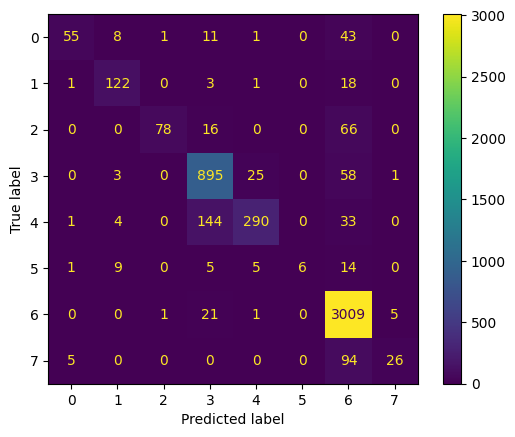

In [81]:
#Confusion matrix
cm30 = confusion_matrix(y_test, y_pred30)
cm_display30 = ConfusionMatrixDisplay(cm30).plot()

cm_display30.figure_.savefig(f'Model/confusionMatrix30_{NAME}.png')

<span style="font-size:xx-large;">**20% of the Train Set**</span>

In [82]:
#Create the train and test subsets to 20%
X_train20, X_test20, y_train20, y_test20 = train_test_split( 
    X_train, 
    y_train, 
    train_size=0.20, 
    random_state=42,
    stratify=y_train
    )

print ('Train set:', X_train20.shape,  y_train20.shape)

Train set: (4063, 104) (4063,)


In [83]:
#Count division
y_train20.value_counts()

class
7    2358
4     807
5     411
2     127
1     110
3     109
8     100
6      41
Name: count, dtype: int64

<span>**Cross validation for better parameters**</span>

In [84]:
'''
classifier20 = RandomForestClassifier(random_state=42)
'''

'\nclassifier20 = RandomForestClassifier(random_state=42)\n'

In [85]:
'''
CV_rfc20 = GridSearchCV(estimator=classifier20, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc20.fit(X_train20, y_train20)
'''

'\nCV_rfc20 = GridSearchCV(estimator=classifier20, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc20.fit(X_train20, y_train20)\n'

In [86]:
'''
CV_rfc20.best_params_
'''

'\nCV_rfc20.best_params_\n'

In [87]:
'''
classifier20 = CV_rfc20.best_estimator_
'''

'\nclassifier20 = CV_rfc20.best_estimator_\n'

<span>**End of cross validation for better parameters**</span>

In [88]:

param_gr20 = {
    'n_estimators': 900,
    'max_features': 'sqrt',
    'max_depth' : None,
    'criterion' :'entropy',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
}


In [89]:

#Create the RF object. Hyperparameters obtained from Data transformation
classifier20 = RandomForestClassifier(**param_gr20)


<span>**Model 20 construction**</span>

In [90]:
%%time
classifier20.fit(X_train20, y_train20)

CPU times: total: 1min 9s
Wall time: 10.7 s


RandomForestClassifier(criterion='entropy', n_estimators=900, n_jobs=7,
                       random_state=42, warm_start=True)

<span style="font-size:large;">**Validation for 20%**</span>

In [91]:
score20 = classifier20.score(X_test, y_test)
print('Average accuracy score: {}'.format(score20))

Average accuracy score: 0.872244094488189


In [92]:
#Calculate the model save results
y_pred20 = classifier20.predict(X_test)

In [93]:
#F1 report
report20 = classification_report(y_test, y_pred20)
print("Classification Report:\n", report20)

with open(f'Model/ClassificationReport20_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report20)

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.36      0.50       119
           2       0.78      0.77      0.77       145
           3       0.94      0.46      0.62       160
           4       0.81      0.90      0.85       982
           5       0.89      0.60      0.72       472
           6       1.00      0.10      0.18        40
           7       0.89      0.99      0.94      3037
           8       0.75      0.17      0.27       125

    accuracy                           0.87      5080
   macro avg       0.86      0.54      0.61      5080
weighted avg       0.87      0.87      0.86      5080



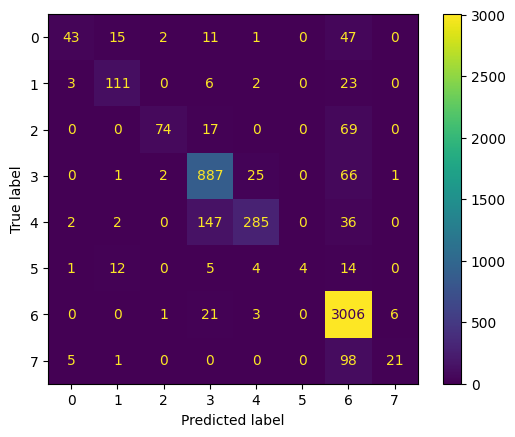

In [94]:
#Confusion matrix
cm20 = confusion_matrix(y_test, y_pred20)
cm_display20 = ConfusionMatrixDisplay(cm20).plot()

cm_display20.figure_.savefig(f'Model/confusionMatrix20_{NAME}.png')

<span style="font-size:xx-large;">**10% of the Train Set**</span>

In [95]:
#Create the train and test subsets to 20%
X_train10, X_test10, y_train10, y_test10 = train_test_split( 
    X_train, 
    y_train, 
    train_size=0.10, 
    random_state=42,
    stratify=y_train
    )

print ('Train set:', X_train10.shape,  y_train10.shape)

Train set: (2031, 104) (2031,)


In [96]:
#Count division
y_train10.value_counts()

class
7    1178
4     403
5     205
2      64
3      55
1      55
8      50
6      21
Name: count, dtype: int64

<span>**Cross validation for better parameters**</span>

In [97]:
'''
classifier10 = RandomForestClassifier(random_state=42)
'''

'\nclassifier10 = RandomForestClassifier(random_state=42)\n'

In [98]:
'''
CV_rfc10 = GridSearchCV(estimator=classifier10, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc10.fit(X_train10, y_train10)
'''

'\nCV_rfc10 = GridSearchCV(estimator=classifier10, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc10.fit(X_train10, y_train10)\n'

In [99]:
'''
CV_rfc10.best_params_
'''

'\nCV_rfc10.best_params_\n'

In [100]:
'''
classifier10 = CV_rfc10.best_estimator_
'''

'\nclassifier10 = CV_rfc10.best_estimator_\n'

<span>**End of cross validation for better parameters**</span>

In [101]:

param_gr10 = {
    'n_estimators': 400,
    'max_features': 'log2',
    'max_depth' : None,
    'criterion' :'entropy',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
}


In [102]:

#Create the RF object. Hyperparameters obtained from Data transformation
classifier10 = RandomForestClassifier(**param_gr10)


<span>**Model 10 construction**</span>

In [103]:
%%time
classifier10.fit(X_train10, y_train10)

CPU times: total: 8.62 s
Wall time: 1.51 s


RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=400, n_jobs=7, random_state=42,
                       warm_start=True)

<span style="font-size:large;">**Validation for 10%**</span>

In [104]:
score10 = classifier10.score(X_test, y_test)
print('Average accuracy score: {}'.format(score10))

Average accuracy score: 0.8515748031496063


In [105]:
#Calculate the model save results
y_pred10 = classifier10.predict(X_test)

In [106]:
#F1 report
report10 = classification_report(y_test, y_pred10)
print("Classification Report:\n", report10)

with open(f'Model/ClassificationReport10_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report10)

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.20      0.33       119
           2       0.69      0.72      0.71       145
           3       0.94      0.30      0.45       160
           4       0.80      0.89      0.84       982
           5       0.89      0.56      0.69       472
           6       1.00      0.03      0.05        40
           7       0.87      0.99      0.93      3037
           8       0.67      0.06      0.12       125

    accuracy                           0.85      5080
   macro avg       0.84      0.47      0.51      5080
weighted avg       0.85      0.85      0.83      5080



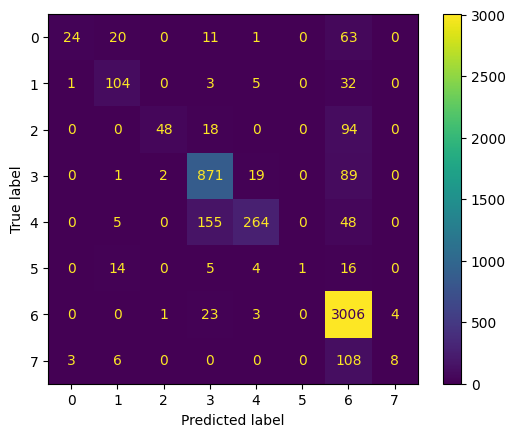

In [107]:
#Confusion matrix
cm10 = confusion_matrix(y_test, y_pred10)
cm_display10 = ConfusionMatrixDisplay(cm10).plot()

cm_display10.figure_.savefig(f'Model/confusionMatrix10_{NAME}.png')

<span style="font-size:xx-large;">**5% of the Train Set**</span>

In [108]:
#Create the train and test subsets to 20%
X_train5, X_test5, y_train5, y_test5 = train_test_split( 
    X_train, 
    y_train, 
    train_size=0.05, 
    random_state=42,
    stratify=y_train
    )

print ('Train set:', X_train5.shape,  y_train5.shape)

Train set: (1015, 104) (1015,)


In [109]:
#Contar divisão
y_train5.value_counts()

class
7    589
4    202
5    103
2     32
3     27
1     27
8     25
6     10
Name: count, dtype: int64

<span>**Cross validation for better parameters**</span>

In [110]:
'''
classifier5 = RandomForestClassifier(random_state=42)
'''

'\nclassifier5 = RandomForestClassifier(random_state=42)\n'

In [111]:
'''
CV_rfc5 = GridSearchCV(estimator=classifier5, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)
CV_rfc5.fit(X_train5, y_train5)
'''

'\nCV_rfc5 = GridSearchCV(estimator=classifier5, param_grid=param_grCV, cv=5, n_jobs=CPUsselected)\nCV_rfc5.fit(X_train5, y_train5)\n'

In [112]:
'''
CV_rfc5.best_params_
'''

'\nCV_rfc5.best_params_\n'

In [113]:
'''
classifier5 = CV_rfc5.best_estimator_
'''

'\nclassifier5 = CV_rfc5.best_estimator_\n'

<span>**End of cross validation for better parameters**</span>

In [114]:

param_gr5 = {
    'n_estimators': 500,
    'max_features': 'log2',
    'max_depth' : None,
    'criterion' :'entropy',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':CPUsselected,
    'random_state':42,
    'verbose':0,
    'warm_start':True,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None
}


In [115]:

#Create the RF object. Hyperparameters obtained from Data transformation
classifier5 = RandomForestClassifier(**param_gr5)


<span>**Model 5 construction**</span>

In [116]:
%%time
classifier5.fit(X_train5, y_train5)

CPU times: total: 5.17 s
Wall time: 1.23 s


RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=500, n_jobs=7, random_state=42,
                       warm_start=True)

<span style="font-size:large;">**Validation for 5%**</span>

In [117]:
score5 = classifier5.score(X_test, y_test)
print('Average accuracy score: {}'.format(score5))

Average accuracy score: 0.8291338582677166


In [118]:
#Calculate the model save results
y_pred5 = classifier5.predict(X_test)

In [119]:
#F1 report
report5 = classification_report(y_test, y_pred5)
print("Classification Report:\n", report5)

with open(f'Model/ClassificationReport5_{NAME}.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report5)

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.10      0.18       119
           2       0.64      0.65      0.65       145
           3       0.91      0.19      0.32       160
           4       0.76      0.86      0.81       982
           5       0.89      0.51      0.65       472
           6       0.00      0.00      0.00        40
           7       0.85      0.98      0.91      3037
           8       0.47      0.06      0.10       125

    accuracy                           0.83      5080
   macro avg       0.66      0.42      0.45      5080
weighted avg       0.82      0.83      0.80      5080



C:\Users\mmquintela\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mmquintela\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mmquintela\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

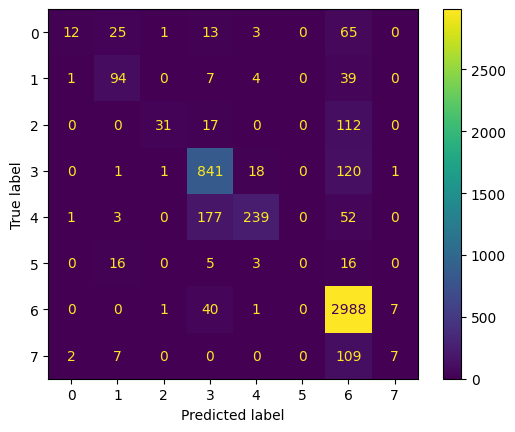

In [120]:
#Confusion matrix 
cm5 = confusion_matrix(y_test, y_pred5)
cm_display5 = ConfusionMatrixDisplay(cm5).plot()

cm_display5.figure_.savefig(f'Model/confusionMatrix5_{NAME}.png')

<span style="font-size:xx-large;">**THE END**</span>